Saving Microsoft.csv to Microsoft.csv
Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Instructions for updating:
Use tf.cast instead.
Epoch 1/3
 - 154s - loss: 3.6786e-04
Epoch 2/3
 - 152s - loss: 1.7446e-04
Epoch 3/3
 - 151s - loss: 1.1169e-04


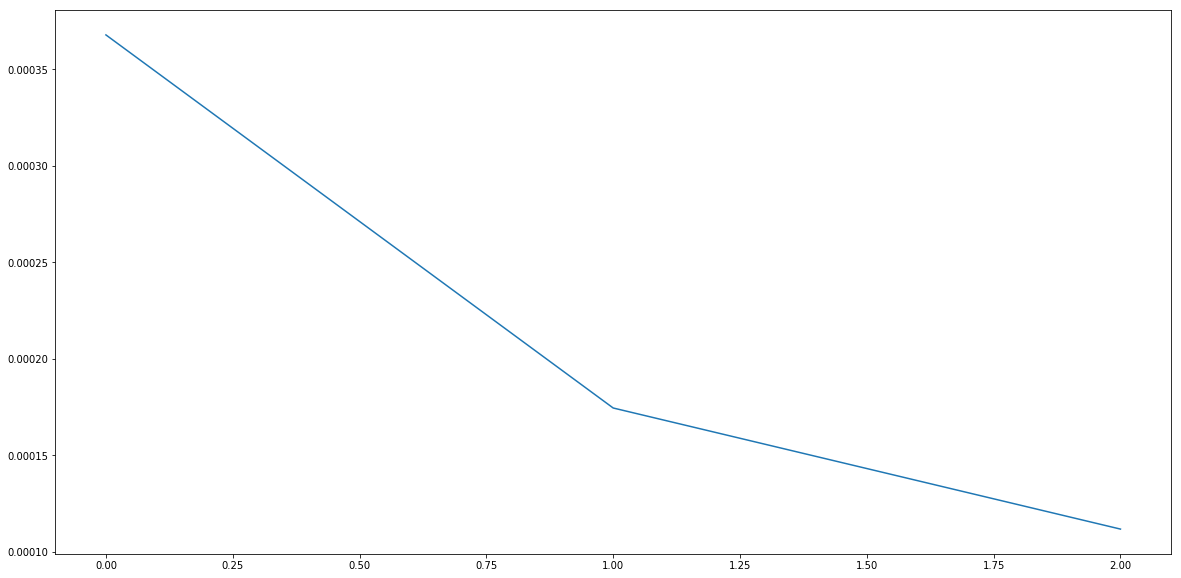

Mean Squared Error = 173.16598491204383


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


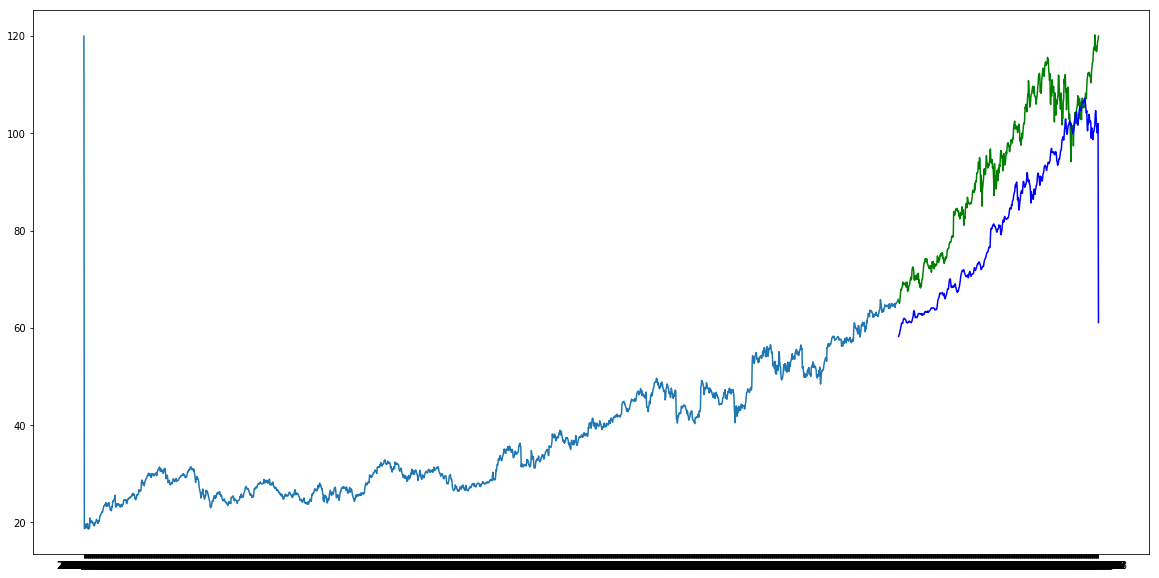

In [2]:

'''
Date: 04/13/2019

Input: Microsoft daily stock price history => training and testing data
The program: Use the first a% closing prices to predict the last (100-a)% closing prices
ML method: LSTM
Output: a graph comparing the true prices and predicted prices
        and performance mesures
        
Credit: The base of this program is taken from 
https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/
'''

#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from google.colab import files #read files from local machine
import io


#import packages
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error

#to plot within notebook
import matplotlib.pyplot as plt

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))


#GLOBAL VARIABLES
LAG = 100
TRAIN_DATA_PERCENTAGE = 0.8
N_EPOCHS = 3
N_DAYS_TO_PREDICT=10


#open a file (dataset)
uploaded = files.upload()
  
#get filename
for fn in uploaded.keys():
  filename = fn
    
#Read the file, ask pandas to recognize the dates, set 'date' as index column
df = pd.read_csv(io.BytesIO(uploaded[filename]))
  
#creating dataframe

df = df.sort_index(ascending=True, axis=0)

new_data = pd.DataFrame(index=range(0,len(df)),columns=['date', 'close'])

for i in range(0,len(df)):
    new_data['date'][i] = df['date'][i]
    new_data['close'][i] = df['close'][i]

#re-order the data in increment of time
new_data = new_data.sort_values('date')
new_data = new_data.reset_index(drop=True)


#setting index
new_data.index = new_data.date
new_data.drop('date', axis=1, inplace=True)


#creating train and test sets
dataset = new_data.values

index_to_split = int(TRAIN_DATA_PERCENTAGE * len(dataset))

train = dataset[0:index_to_split,:]
valid = new_data[index_to_split+N_DAYS_TO_PREDICT-1:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(LAG,len(train)):
    x_train.append(scaled_data[i-LAG:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))





#predicting 246 values, using past LAG from the train data
inputs = new_data[len(new_data) - len(valid) - LAG:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(LAG,inputs.shape[0]):
    X_test.append(inputs[i-LAG:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

# want to repeat the same experiment for 'repeat' times to obtain more accurate results
repeat = 1
plt.figure()
for i in range(repeat):
  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
  model.add(LSTM(units=50))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam')
  history = model.fit(x_train, y_train, epochs=N_EPOCHS, batch_size=1, verbose=2)
  hist = pd.DataFrame(history.history)
  plt.plot(hist['loss']) #train_mse

  closing_price = model.predict(X_test)
  #print (closing_price)
  #len_closing_price = len(closing_price)
  #print (X_test)
  #print(len(X_test))
  #print("---------------------------")
  for i in range(N_DAYS_TO_PREDICT - 1):
    X_test = np.delete(X_test, [[0]])
    #print (X_test)
    #print(len(X_test))
    #print ("---------------")
    X_test = np.append(X_test, closing_price[0][0])
    #print (X_test)
    #print(len(X_test))
    #print ("---------------")
    X_test = np.reshape(X_test, (int(len(X_test)/LAG),LAG,1))
    #print (X_test)
    #print(len(X_test))
    #print ("---------------")
    closing_price = model.predict(X_test)
        
  #print (X_test)
  
  #update X_test
      
  
  
  
  
  
  #test_mse = sqrt(mean_squared_error(y_test, closing_price))
  #hist['loss1']
  #plt.plot(hist['loss1']) #test_mse
  closing_price = scaler.inverse_transform(closing_price)

plt.show()
                   

train = new_data[:index_to_split]
valid = new_data[index_to_split+N_DAYS_TO_PREDICT-1:]

#MSE
mse = mean_squared_error(valid[['close']], closing_price)
print("Mean Squared Error = " + str(mse))


#for plotting
valid['Predictions'] = closing_price

plt.plot(train['close'])
plt.plot(valid[['close']], color='green')
plt.plot(valid[['Predictions']], color='blue')
plt.show()
